In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy all edf files to same place for easier conversion to ascii
""" source_folder = "/Users/dako/Downloads/VISCOM/all_king_devick"  # Change this to your actual source folder path
destination_folder = "/Users/dako/Desktop/KD_edf"  # Change this to your actual destination folder path

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate over subfolders and copy .edf files
for root, _, files in os.walk(source_folder):
    for file in files:
        if file.endswith(".EDF"):
            source_file = os.path.join(root, file)
            destination_file = os.path.join(destination_folder, file)
            
            # Ensure unique filenames if multiple subfolders have same file name
            if os.path.exists(destination_file):
                filename, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(os.path.join(destination_folder, f"{filename}_{counter}{ext}")):
                    counter += 1
                destination_file = os.path.join(destination_folder, f"{filename}_{counter}{ext}")

            shutil.copy2(source_file, destination_file)  # Preserve metadata
            print(f"Copied: {source_file} -> {destination_file}")

print("All .edf files have been copied successfully.") """

' source_folder = "/Users/dako/Downloads/VISCOM/all_king_devick"  # Change this to your actual source folder path\ndestination_folder = "/Users/dako/Desktop/KD_edf"  # Change this to your actual destination folder path\n\n# Ensure the destination folder exists\nos.makedirs(destination_folder, exist_ok=True)\n\n# Iterate over subfolders and copy .edf files\nfor root, _, files in os.walk(source_folder):\n    for file in files:\n        if file.endswith(".EDF"):\n            source_file = os.path.join(root, file)\n            destination_file = os.path.join(destination_folder, file)\n            \n            # Ensure unique filenames if multiple subfolders have same file name\n            if os.path.exists(destination_file):\n                filename, ext = os.path.splitext(file)\n                counter = 1\n                while os.path.exists(os.path.join(destination_folder, f"{filename}_{counter}{ext}")):\n                    counter += 1\n                destination_file = os.path.j

In [ ]:
# Load the participant info Excel file
file_path = "/Users/dako/Downloads/VISCOM/info (1).xlsx" 
df = pd.read_excel(file_path)

In [3]:
# Define the directory containing ASC files
asc_directory = "/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/" 

# List all ASC files in the directory
asc_files = [f for f in os.listdir(asc_directory) if f.endswith('.asc')]

# Display the files to confirm
print("Files to process:", asc_files)

Files to process: ['FittsLaw_87_0.asc', 'FittsLaw_89_0.asc', 'Fixations_317_0.asc', 'Fixations_322_0.asc', 'KingDevick_128_2.asc', 'KingDevick_133_1.asc', 'Patterns_141_1.asc', 'Patterns_142_2.asc', 'Reaction_146_0.asc', 'Reaction_147_2.asc', 'Shapes_137_0.asc', 'Shapes_138_1.asc', 'SmoothPursuits_133_1.asc', 'SmoothPursuits_134_1.asc']


In [10]:
def process_file_trials(file_path):
    """
    Process a single ASC file to extract trial events for the new task.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    events = []
    current_trial_id = None  # Keep track of the current trial ID

    # Parse the lines
    for line in lines:
        line = line.strip()
        parts = line.split()

        # Detect trial start marked by "TRIALID"
        if "TRIALID" in line:
            current_trial_id = int(parts[-1])  # Extract trial ID
            time = int(parts[1])  # Extract time
            events.append({
                "trial_id": current_trial_id, 
                "time": time, 
                "event": "TRIALID", 
                "time_elapsed_ms": None, 
                "num_mistakes": None
            })

        # Detect START line, marking the beginning of the trial
        elif line.startswith("START"):
            time = int(parts[1])  # Extract time
            events.append({
                "trial_id": current_trial_id, 
                "time": time, 
                "event": "START", 
                "time_elapsed_ms": None, 
                "num_mistakes": None
            })

        # Detect END line, marking the end of the trial
        elif line.startswith("END"):
            time = int(parts[1])  # Extract time
            events.append({
                "trial_id": current_trial_id, 
                "time": time, 
                "event": "END", 
                "time_elapsed_ms": None, 
                "num_mistakes": None
            })

        # Detect "!V TRIAL_VAR_DATA" which contains both num_mistakes and time_elapsed
        elif "!V TRIAL_VAR_DATA" in line:
            #print("DEBUG: parts = ", parts)
            time = int(parts[1])  # Extract time
            num_mistakes = int(parts[-2])  # Extract first number (mistakes)
            time_elapsed_ms = int(float(parts[-1]) * 1000)  # Convert last number to ms
            events.append({
                "trial_id": current_trial_id, 
                "time": time, 
                "event": "TRIAL_VAR_DATA", 
                "time_elapsed_ms": time_elapsed_ms, 
                "num_mistakes": num_mistakes
            })

    # Convert events to a DataFrame
    events_df = pd.DataFrame(events)

    # Sort by trial_id and time
    events_df = events_df.sort_values(by=["trial_id", "time"]).reset_index(drop=True)

    return events_df


# Process multiple files
data_directory = "/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/"  # Replace with your directory path
all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.asc')]

combined_df = pd.DataFrame()

for file_path in all_files:
    print(file_path)
    if "King" in file_path:
        #print(f"Processing file: {file_path}")  # Debug: Print current file
        events_df = process_file_trials(file_path)
        events_df['file_name'] = os.path.basename(file_path)  # Add file identifier
        combined_df = pd.concat([combined_df, events_df], ignore_index=True)

# Extract participant ID from the filename
combined_df['participant_id'] = combined_df['file_name'].str.extract(r'KingDevick_(\d+)_')
combined_df['participant_id'] = combined_df['participant_id'].astype(int)

# Drop file_name column
combined_df = combined_df.drop(columns=['file_name'])

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/FittsLaw_87_0.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/FittsLaw_89_0.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/Fixations_317_0.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/Fixations_322_0.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/KingDevick_128_2.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/KingDevick_133_1.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/Patterns_141_1.asc
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/data/asc_files/Patterns_142_2.asc
/mnt

In [11]:
combined_df

,trial_id,time,event,time_elapsed_ms,num_mistakes,participant_id
0,0,2817415,TRIALID,NaN,NaN,128
1,0,2817449,START,NaN,NaN,128
2,0,2834002,TRIAL_VAR_DATA,10507.0,0.0,128
3,0,2834106,END,NaN,NaN,128
4,1,2835172,TRIALID,NaN,NaN,128
5,1,2835179,START,NaN,NaN,128
6,1,2855933,TRIAL_VAR_DATA,16534.0,0.0,128
7,1,2856037,END,NaN,NaN,128
8,2,2857170,TRIALID,NaN,NaN,128
9,2,2857177,START,NaN,NaN,128


In [13]:
# Extract necessary values for each trial
trial_summary = combined_df.pivot_table(
    index=["participant_id", "trial_id"],
    values=["time", "time_elapsed_ms", "num_mistakes"],
    aggfunc={
        "time": lambda x: x[combined_df.loc[x.index, "event"] == "START"].iloc[0] if any(combined_df.loc[x.index, "event"] == "START") else None,
        "time_elapsed_ms": "first",
        "num_mistakes": "first"
    }
).reset_index()

# Rename columns for clarity
trial_summary.rename(columns={"time": "stimulus_start_time", "time_elapsed_ms": "time_elapsed"}, inplace=True)

# Compute stimulus_end_time by adding time_elapsed to stimulus_start_time
trial_summary["stimulus_end_time"] = trial_summary["stimulus_start_time"] + trial_summary["time_elapsed"]

# Ensure correct column order
trial_summary = trial_summary[["participant_id", "trial_id", "stimulus_start_time", "stimulus_end_time", "num_mistakes", "time_elapsed"]]

# Convert to integer to remove decimal places
trial_summary["stimulus_end_time"] = trial_summary["stimulus_end_time"].astype(int)
trial_summary["time_elapsed"] = trial_summary["time_elapsed"].astype(int)

# Convert num_mistakes to integer if necessary
trial_summary["num_mistakes"] = trial_summary["num_mistakes"].astype(int)

trial_summary['trial_id'] = trial_summary['trial_id'].astype(int)

# Display the result
(trial_summary)

,participant_id,trial_id,stimulus_start_time,stimulus_end_time,num_mistakes,time_elapsed
0,128,0,2817449,2827956,0,10507
1,128,1,2835179,2851713,0,16534
2,128,2,2857177,2874778,0,17601
3,133,0,2119461,2128994,0,9533
4,133,1,2137660,2154469,0,16809
5,133,2,2161448,2182398,0,20950


In [14]:
# Create the 'condition' column in trial_summary by mapping participant_id to Group from df
trial_summary['condition'] = trial_summary['participant_id'].map(df.set_index('ID')['Group'])

NameError: name 'df' is not defined

In [15]:
def parse_metadata(filename):
    """
    Extract metadata (e.g., participant ID, condition) from a filename.
    Assumes filename structure: participantID_condition_XXX.asc.
    """
    # Remove the file extension
    base = os.path.splitext(filename)[0]
    
    # Split the base name into components (assuming underscores separate variables)
    parts = base.split('_')
    
    # Adjust indices according to your naming convention
    participant_id = parts[1]
    condition = parts[0] if len(parts) > 1 else 'unknown'
    
    return participant_id, condition

# Example usage
for file in asc_files:
    pid, cond = parse_metadata(file)
    print(f"File: {file} -> Participant ID: {pid}, Condition: {cond}")

File: FittsLaw_87_0.asc -> Participant ID: 87, Condition: FittsLaw
File: FittsLaw_89_0.asc -> Participant ID: 89, Condition: FittsLaw
File: Fixations_317_0.asc -> Participant ID: 317, Condition: Fixations
File: Fixations_322_0.asc -> Participant ID: 322, Condition: Fixations
File: KingDevick_128_2.asc -> Participant ID: 128, Condition: KingDevick
File: KingDevick_133_1.asc -> Participant ID: 133, Condition: KingDevick
File: Patterns_141_1.asc -> Participant ID: 141, Condition: Patterns
File: Patterns_142_2.asc -> Participant ID: 142, Condition: Patterns
File: Reaction_146_0.asc -> Participant ID: 146, Condition: Reaction
File: Reaction_147_2.asc -> Participant ID: 147, Condition: Reaction
File: Shapes_137_0.asc -> Participant ID: 137, Condition: Shapes
File: Shapes_138_1.asc -> Participant ID: 138, Condition: Shapes
File: SmoothPursuits_133_1.asc -> Participant ID: 133, Condition: SmoothPursuits
File: SmoothPursuits_134_1.asc -> Participant ID: 134, Condition: SmoothPursuits


In [16]:
trial_summary_ryan = trial_summary.copy()
trial_summary_ryan['time_elapsed (s)'] = trial_summary_ryan['time_elapsed'] / 1000  # Convert ms to seconds
trial_summary_ryan = trial_summary_ryan.drop(columns=["stimulus_start_time", "stimulus_end_time", "time_elapsed"])
trial_summary_ryan.to_csv("KingDevick_time_mistakes.csv", index=False)

In [17]:
import pandas as pd
import numpy as np

def process_file(file_path, participant_id, condition):
    """
    Process a single ASC file to extract fixations, saccades, and trials,
    including detailed trial event data like stimulus onset.
    Handles malformed lines by filling missing or invalid values with NaN.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize containers
    fixations = []
    saccades = []
    events = []
    current_trial_id = None  # Keep track of the current trial ID

    # Parse the lines
    for line in lines:
        line = line.strip()

        # Fixations
        if line.startswith("EFIX"):
            parts = line.split()
            fixations.append({
                "trial_id": current_trial_id,
                "eye": parts[1] if len(parts) > 1 else np.nan,
                "start_time": int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else np.nan,
                "end_time": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else np.nan,
                "duration": int(parts[4]) if len(parts) > 4 and parts[4].isdigit() else np.nan,
                "x": float(parts[5]) if len(parts) > 5 and parts[5].replace('.', '', 1).isdigit() else np.nan,
                "y": float(parts[6]) if len(parts) > 6 and parts[6].replace('.', '', 1).isdigit() else np.nan,
                "avg_pupil_size": float(parts[7]) if len(parts) > 7 and parts[7].replace('.', '', 1).isdigit() else np.nan,
                "participant_id": participant_id,
                "condition": condition,
            })

        # Saccades
        elif line.startswith("ESACC"):
            parts = line.split()
            saccades.append({
                "trial_id": current_trial_id,
                "eye": parts[1] if len(parts) > 1 else np.nan,
                "start_time": int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else np.nan,
                "end_time": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else np.nan,
                "duration": int(parts[4]) if len(parts) > 4 and parts[4].isdigit() else np.nan,
                "start_x": float(parts[5]) if len(parts) > 5 and parts[5].replace('.', '', 1).isdigit() else np.nan,
                "start_y": float(parts[6]) if len(parts) > 6 and parts[6].replace('.', '', 1).isdigit() else np.nan,
                "end_x": float(parts[7]) if len(parts) > 7 and parts[7].replace('.', '', 1).isdigit() else np.nan,
                "end_y": float(parts[8]) if len(parts) > 8 and parts[8].replace('.', '', 1).isdigit() else np.nan,
                "amplitude": float(parts[9]) if len(parts) > 9 and parts[9].replace('.', '', 1).isdigit() else np.nan,
                "peak_velocity": float(parts[10]) if len(parts) > 10 and parts[10].replace('.', '', 1).isdigit() else np.nan,
                "participant_id": participant_id,
                "condition": condition,
            })

        # Trial events
        elif "TRIALID" in line:
            #print(f"DEBUG: TRIALID line found: {line}")  # Print the line for debugging
            current_trial_id = int(line.split()[-1])  # Update current trial ID
            #print(f"DEBUG: Assigned trial_id = {current_trial_id}")  # Check trial assignment
            time = int(line.split()[1])  # Extract time
            events.append({"trial_id": current_trial_id, "time": time, "event": "TRIALID", "colour": None,  "participant_id": participant_id, "coordinates": None})


    # Convert to DataFrames for fixations and saccades
    fixations_df = pd.DataFrame(fixations)
    saccades_df = pd.DataFrame(saccades)
    events_df = pd.DataFrame(events)
    

    return fixations_df, saccades_df, events_df

In [18]:
import numpy as np

fixations_list = []
saccades_list = []
trials_list = []


for file in asc_files:
    file_path = os.path.join(asc_directory, file)
    participant_id, condition = parse_metadata(file)
    
    fixations_df, saccades_df, events_df = process_file(file_path, participant_id, condition)
    
    fixations_list.append(fixations_df)
    saccades_list.append(saccades_df)
    trials_list.append(events_df)

# Combine all data into single DataFrames
all_fixations = pd.concat(fixations_list, ignore_index=True)
all_saccades = pd.concat(saccades_list, ignore_index=True)
# all_trials = pd.concat(trials_list, ignore_index=True)

In [19]:
print(len(trial_summary['participant_id'].unique()))
print(len(all_saccades['participant_id'].unique()))
print(len(all_fixations['participant_id'].unique()))

2
13
13


In [21]:
all_fixations['participant_id'] = all_fixations['participant_id'].astype(int)
# Extract unique participant IDs from both datasets
unique_trial_summary = set(trial_summary["participant_id"].unique())
unique_all_fixations = set(all_fixations["participant_id"].unique())

# Find differences (participants present in one dataset but not the other)
only_in_trial_summary = unique_trial_summary - unique_all_fixations
only_in_trial_summary # 118 has no valid fixations 

set()

In [22]:
# FOR KING DEVICK CHANGED LOWER BOUND TO 80 - Rapid eye movement for number naming tasks showed lower fixation durations in previous studies
filtered_fixations = all_fixations[(all_fixations["duration"] >= 80) & (all_fixations["duration"] <= 850)]
filtered_saccades = all_saccades[(all_saccades["duration"] >= 5) & (all_saccades["duration"] <= 100)]
filtered_saccades = filtered_saccades[(filtered_saccades["amplitude"] > 0.4) & (filtered_saccades["peak_velocity"] > 0)]
filtered_saccades["average_velocity"] = filtered_saccades["amplitude"] / filtered_saccades["duration"]*1000

In [23]:
filtered_fixations['participant_id'] = filtered_fixations['participant_id'].astype(int)
filtered_saccades['participant_id'] = filtered_saccades['participant_id'].astype(int)

# Create the 'condition' column in trial_summary by mapping participant_id to Group from df
filtered_saccades['condition'] = filtered_saccades['participant_id'].map(df.set_index('ID')['Group'])
filtered_fixations['condition'] = filtered_fixations['participant_id'].map(df.set_index('ID')['Group'])

/tmp/ipykernel_11841/203758570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fixations['participant_id'] = filtered_fixations['participant_id'].astype(int)


NameError: name 'df' is not defined

In [24]:
filtered_fixations.to_csv("KingDevick_all_fixations_patient.csv", index=False)
filtered_saccades.to_csv("KingDevick_all_saccades_patient.csv", index=False)
combined_df.to_csv("KingDevick_all_trials_patient.csv", index=False)

In [25]:
np.unique(filtered_saccades['trial_id'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [26]:
nan_trial_id_rows = all_saccades[all_saccades["trial_id"].isna()]
nan_trial_id_rows # saccades before trial start

,trial_id,eye,start_time,end_time,duration,start_x,start_y,end_x,end_y,amplitude,peak_velocity,participant_id,condition


In [27]:
nan_trial_id_rows = all_fixations[all_fixations["trial_id"].isna()]
nan_trial_id_rows # fixations before trial start

,trial_id,eye,start_time,end_time,duration,x,y,avg_pupil_size,participant_id,condition


In [28]:
filtered_fixations = filtered_fixations.dropna(subset=["trial_id"])
filtered_saccades = filtered_saccades.dropna(subset=["trial_id"])

In [29]:
filtered_fixations["trial_id"] = filtered_fixations["trial_id"].astype(int)
filtered_fixations["participant_id"] = filtered_fixations["participant_id"].astype(int)

# Merge filtered_fixations with trial_summary on participant_id and trial_id
fixations_with_trial_info = pd.merge(
    filtered_fixations, trial_summary, on=["participant_id", "trial_id"], how="left"
)

# Filter data based on time constraints
fixations_with_trial_info = fixations_with_trial_info[
    (fixations_with_trial_info["start_time"] >= fixations_with_trial_info["stimulus_start_time"]) &
    (fixations_with_trial_info["end_time"] <= fixations_with_trial_info["stimulus_end_time"])
]

# Display the merged dataframe
(fixations_with_trial_info)

,trial_id,eye,start_time,end_time,duration,x,y,avg_pupil_size,participant_id,condition,stimulus_start_time,stimulus_end_time,num_mistakes,time_elapsed
1044,0,R,2817456,2817913,457,304.0,275.3,1827.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1045,0,L,2817456,2817915,459,246.7,51.6,2126.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1046,0,L,2817969,2818196,227,594.9,172.5,2231.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1047,0,R,2817975,2818198,223,677.0,357.6,1921.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1048,0,R,2818256,2818439,183,963.3,588.0,2032.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,2,L,2181292,2181506,214,310.7,731.4,1657.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0
1794,2,R,2181294,2181521,227,269.6,694.3,1012.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0
1795,2,R,2181673,2181829,156,276.9,720.2,1062.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0
1796,2,L,2181894,2182050,156,682.0,726.5,1639.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0


In [30]:
filtered_saccades["trial_id"] = filtered_saccades["trial_id"].astype(int)
filtered_saccades["participant_id"] = filtered_saccades["participant_id"].astype(int)

# Merge filtered_fixations with trial_summary on participant_id and trial_id
saccades_with_trial_info = pd.merge(
    filtered_saccades, trial_summary, on=["participant_id", "trial_id"], how="left"
)

# Filter data based on time constraints
saccades_with_trial_info = saccades_with_trial_info[
    (saccades_with_trial_info["start_time"] >= saccades_with_trial_info["stimulus_start_time"]) &
    (saccades_with_trial_info["end_time"] <= saccades_with_trial_info["stimulus_end_time"])
]

# Display the merged dataframe
(saccades_with_trial_info)

,trial_id,eye,start_time,end_time,duration,start_x,start_y,end_x,end_y,amplitude,peak_velocity,participant_id,condition,average_velocity,stimulus_start_time,stimulus_end_time,num_mistakes,time_elapsed
919,0,L,2817916,2817968,52,246.8,46.2,566.8,165.5,6.14,371.0,128,KingDevick,118.076923,2817449.0,2827956.0,0.0,10507.0
920,0,R,2817914,2817974,60,300.8,273.5,688.4,355.3,7.13,349.0,128,KingDevick,118.833333,2817449.0,2827956.0,0.0,10507.0
921,0,L,2818197,2818251,54,596.5,163.8,933.3,484.1,8.46,481.0,128,KingDevick,156.666667,2817449.0,2827956.0,0.0,10507.0
922,0,R,2818199,2818255,56,672.7,360.0,974.4,583.1,6.84,405.0,128,KingDevick,122.142857,2817449.0,2827956.0,0.0,10507.0
923,0,R,2818440,2818450,10,955.1,582.4,966.1,557.5,0.49,60.0,128,KingDevick,49.000000,2817449.0,2827956.0,0.0,10507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,2,R,2181257,2181293,36,359.8,681.1,290.1,685.1,1.22,180.0,133,KingDevick,33.888889,2161448.0,2182398.0,0.0,20950.0
1607,2,R,2181830,2181877,47,281.8,718.6,631.3,720.9,6.16,420.0,133,KingDevick,131.063830,2161448.0,2182398.0,0.0,20950.0
1608,2,L,2181800,2181893,93,297.7,628.7,683.5,718.6,6.99,400.0,133,KingDevick,75.161290,2161448.0,2182398.0,0.0,20950.0
1609,2,L,2182051,2182067,16,678.9,724.7,731.1,723.2,0.94,83.0,133,KingDevick,58.750000,2161448.0,2182398.0,0.0,20950.0


In [22]:
# Save the merged dataframe as a CSV file
fixations_with_trial_info.to_csv("KingDevick_fixations_with_stim_patient.csv", index=False)
saccades_with_trial_info.to_csv("KingDevick_saccades_with_stim_patient.csv", index=False)

# ANALYSIS

In [33]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#king_devick_fixations = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/King_Devick/KingDevick_fixations_with_stim_patient.csv") # pp279 missing due to data corruption
#king_devick_saccades = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/King_Devick/KingDevick_saccades_with_stim_patient.csv") # pp345 missing due to data corruption
king_devick_fixations = fixations_with_trial_info
king_devick_saccades = saccades_with_trial_info

In [39]:
king_devick_fixations

,trial_id,eye,start_time,end_time,duration,x,y,avg_pupil_size,participant_id,condition,stimulus_start_time,stimulus_end_time,num_mistakes,time_elapsed
1044,0,R,2817456,2817913,457,304.0,275.3,1827.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1045,0,L,2817456,2817915,459,246.7,51.6,2126.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1046,0,L,2817969,2818196,227,594.9,172.5,2231.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1047,0,R,2817975,2818198,223,677.0,357.6,1921.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
1048,0,R,2818256,2818439,183,963.3,588.0,2032.0,128,KingDevick,2817449.0,2827956.0,0.0,10507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,2,L,2181292,2181506,214,310.7,731.4,1657.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0
1794,2,R,2181294,2181521,227,269.6,694.3,1012.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0
1795,2,R,2181673,2181829,156,276.9,720.2,1062.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0
1796,2,L,2181894,2182050,156,682.0,726.5,1639.0,133,KingDevick,2161448.0,2182398.0,0.0,20950.0


In [40]:
# Merge condition_x and condition_y into a single column
king_devick_fixations["condition"] = king_devick_fixations["condition_x"]
king_devick_fixations = king_devick_fixations.drop(columns=["condition_x", "condition_y"])

king_devick_saccades["condition"] = king_devick_saccades["condition_x"]
king_devick_saccades = king_devick_saccades.drop(columns=["condition_x", "condition_y"])

KeyError: 'condition_x'

In [41]:
king_devick_saccades = king_devick_saccades.sort_values(by=["participant_id", "trial_id", "start_time"]).reset_index(drop=True)
king_devick_fixations = king_devick_fixations.sort_values(by=["participant_id", "trial_id", "start_time"]).reset_index(drop=True)

In [42]:
saccades_eye_counts = king_devick_saccades["eye"].value_counts() # R > L
fixations_eye_counts = king_devick_fixations["eye"].value_counts() # R > L
print(saccades_eye_counts)
print(fixations_eye_counts) # only use right eye

eye
L    268
R    267
Name: count, dtype: int64
eye
R    288
L    286
Name: count, dtype: int64


In [43]:
king_devick_saccades_right = king_devick_saccades[king_devick_saccades["eye"] == "R"]
king_devick_fixations_right = king_devick_fixations[king_devick_fixations["eye"] == "R"]

In [44]:
king_devick_saccades_right['num_mistakes'] = king_devick_saccades_right['num_mistakes'].astype(int)
king_devick_fixations_right['num_mistakes'] = king_devick_fixations_right['num_mistakes'].astype(int)

king_devick_saccades_right['participant_id'] = king_devick_saccades_right['participant_id'].astype(int)
king_devick_fixations_right['participant_id'] = king_devick_fixations_right['participant_id'].astype(int)

king_devick_saccades_right['trial_id'] = king_devick_saccades_right['trial_id'].astype(int)
king_devick_fixations_right['trial_id'] = king_devick_fixations_right['trial_id'].astype(int)

/tmp/ipykernel_11841/2601266357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_devick_saccades_right['num_mistakes'] = king_devick_saccades_right['num_mistakes'].astype(int)
/tmp/ipykernel_11841/2601266357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_devick_fixations_right['num_mistakes'] = king_devick_fixations_right['num_mistakes'].astype(int)
/tmp/ipykernel_11841/2601266357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [45]:
king_devick_saccades_right

,trial_id,eye,start_time,end_time,duration,start_x,start_y,end_x,end_y,amplitude,peak_velocity,participant_id,condition,average_velocity,stimulus_start_time,stimulus_end_time,num_mistakes,time_elapsed
0,0,R,2817914,2817974,60,300.8,273.5,688.4,355.3,7.13,349.0,128,KingDevick,118.833333,2817449.0,2827956.0,0,10507.0
3,0,R,2818199,2818255,56,672.7,360.0,974.4,583.1,6.84,405.0,128,KingDevick,122.142857,2817449.0,2827956.0,0,10507.0
4,0,R,2818440,2818450,10,955.1,582.4,966.1,557.5,0.49,60.0,128,KingDevick,49.000000,2817449.0,2827956.0,0,10507.0
6,0,R,2820387,2820433,46,990.5,582.8,660.7,433.4,6.60,291.0,128,KingDevick,143.478261,2817449.0,2827956.0,0,10507.0
7,0,R,2820798,2820855,57,636.8,418.3,903.2,491.5,5.05,259.0,128,KingDevick,88.596491,2817449.0,2827956.0,0,10507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,2,R,2180562,2180611,49,1338.9,682.0,1632.8,684.6,5.19,300.0,133,KingDevick,105.918367,2161448.0,2182398.0,0,20950.0
528,2,R,2181013,2181109,96,1662.2,672.7,365.1,669.3,22.62,484.0,133,KingDevick,235.625000,2161448.0,2182398.0,0,20950.0
530,2,R,2181257,2181293,36,359.8,681.1,290.1,685.1,1.22,180.0,133,KingDevick,33.888889,2161448.0,2182398.0,0,20950.0
532,2,R,2181830,2181877,47,281.8,718.6,631.3,720.9,6.16,420.0,133,KingDevick,131.063830,2161448.0,2182398.0,0,20950.0


/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


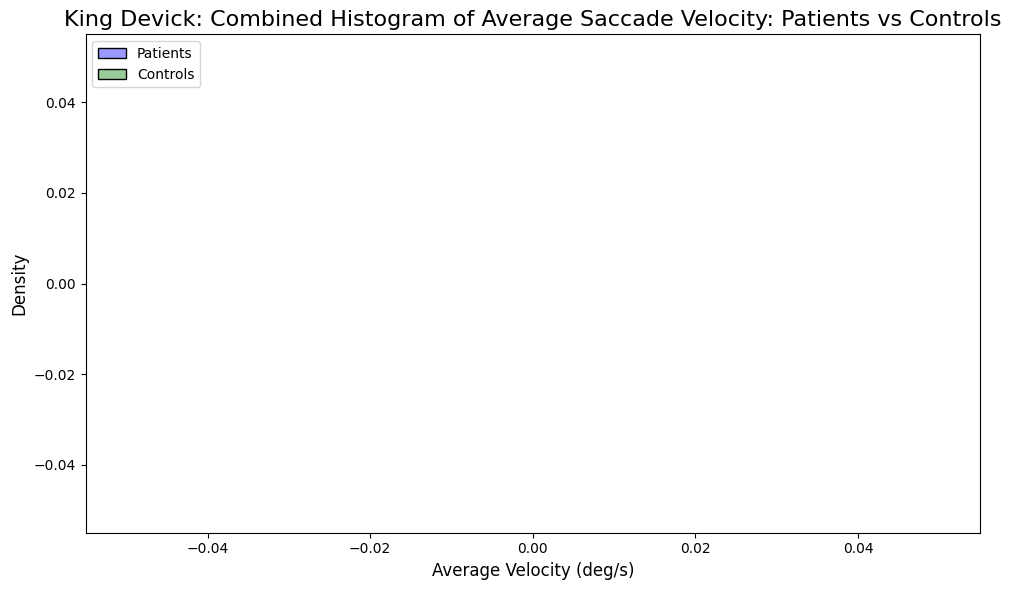

In [46]:
# Combined plot for both groups with density
plt.figure(figsize=(10, 6))
sns.histplot(
    data=king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"],
    x="average_velocity",
    kde=True,
    bins=30,
    color="blue",
    alpha=0.4,
    label="Patients",
    stat="density"  # Normalize to density
)
sns.histplot(
    data=king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"],
    x="average_velocity",
    kde=True,
    bins=30,
    color="green",
    alpha=0.4,
    label="Controls",
    stat="density"  # Normalize to density
)
plt.title("King Devick: Combined Histogram of Average Saccade Velocity: Patients vs Controls", fontsize=16)
plt.xlabel("Average Velocity (deg/s)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


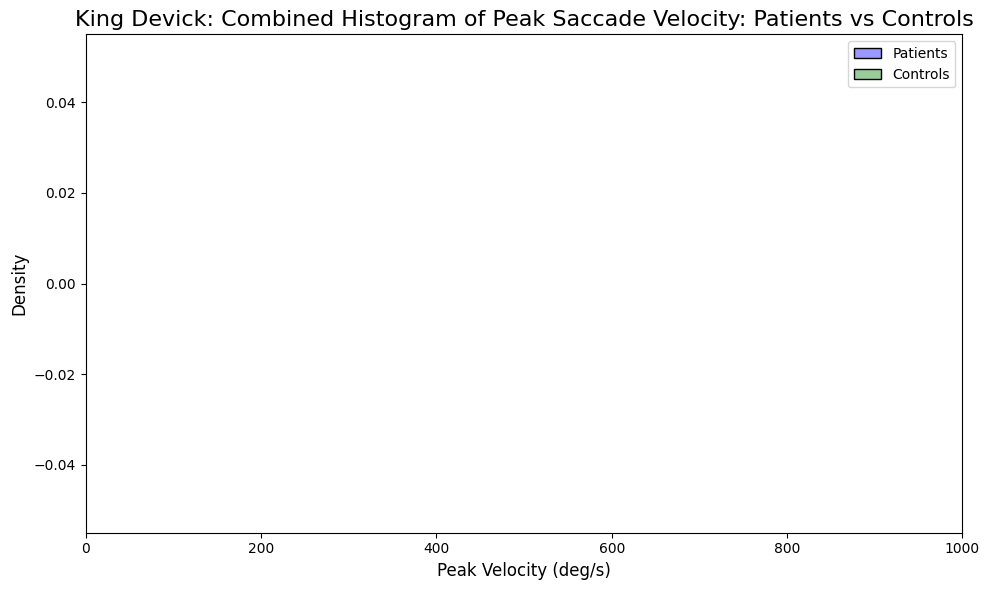

In [47]:
# Combined plot for both groups with density
plt.figure(figsize=(10, 6))
sns.histplot(
    data=king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"],
    x="peak_velocity",
    kde=True,
    bins=30,
    color="blue",
    alpha=0.4,
    label="Patients",
    stat="density"  # Normalize to density
)
sns.histplot(
    data=king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"],
    x="peak_velocity",
    kde=True,
    bins=30,
    color="green",
    alpha=0.4,
    label="Controls",
    stat="density"  # Normalize to density
)
plt.title("King Devick: Combined Histogram of Peak Saccade Velocity: Patients vs Controls", fontsize=16)
plt.xlabel("Peak Velocity (deg/s)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.xlim(None, 1000)
plt.tight_layout()
plt.show()

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


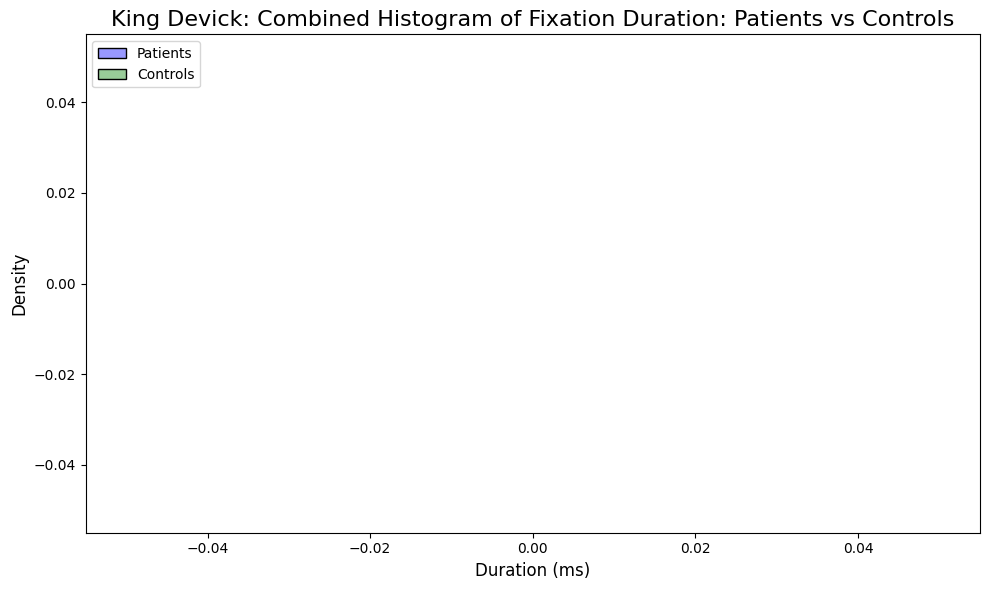

In [48]:
# Combined plot for both groups with density
plt.figure(figsize=(10, 6))
sns.histplot(
    data=king_devick_fixations_right[king_devick_fixations_right["condition"] == "PATIENT"],
    x="duration",
    kde=True,
    bins=30,
    color="blue",
    alpha=0.4,
    label="Patients",
    stat="density"  # Normalize to density
)
sns.histplot(
    data=king_devick_fixations_right[king_devick_fixations_right["condition"] == "CONTROL"],
    x="duration",
    kde=True,
    bins=30,
    color="green",
    alpha=0.4,
    label="Controls",
    stat="density"  # Normalize to density
)
plt.title("King Devick: Combined Histogram of Fixation Duration: Patients vs Controls", fontsize=16)
plt.xlabel("Duration (ms)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_11841/2318382806.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


ValueError: 'yerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

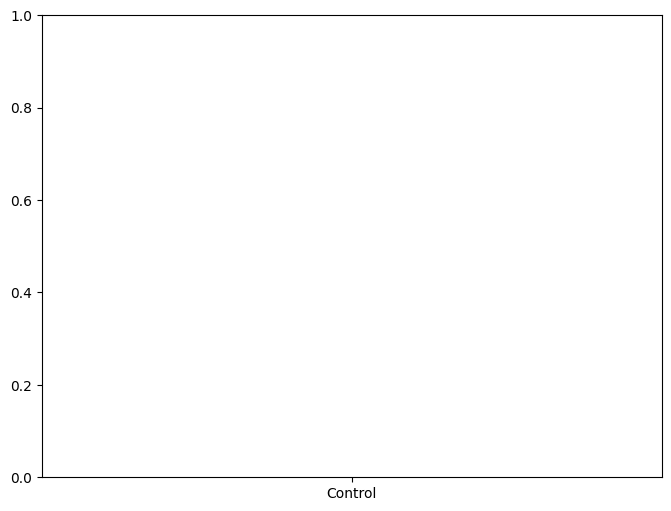

In [49]:
# Function to summarize fixation durations
def summarize_fixation_durations(df, label):
    n = len(df["participant_id"].unique())  # Unique participants per group
    mean_duration = df["duration"].mean()
    sd = np.std(df["duration"], ddof=1)
    se_duration = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_duration": mean_duration, "sd": sd, "se_duration": se_duration}

# Summarize fixation durations for controls and patients
fixation_summary = pd.DataFrame([
    summarize_fixation_durations(king_devick_fixations_right[king_devick_fixations_right["condition"] == "CONTROL"], "Control"),
    summarize_fixation_durations(king_devick_fixations_right[king_devick_fixations_right["condition"] == "PATIENT"], "Patient")
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=fixation_summary, 
    x="group", 
    y="mean_duration", 
    yerr=fixation_summary["se_duration"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("King Devick: Mean Fixation Durations: Patients vs Controls")
plt.ylabel("Mean Fixation Duration (ms)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

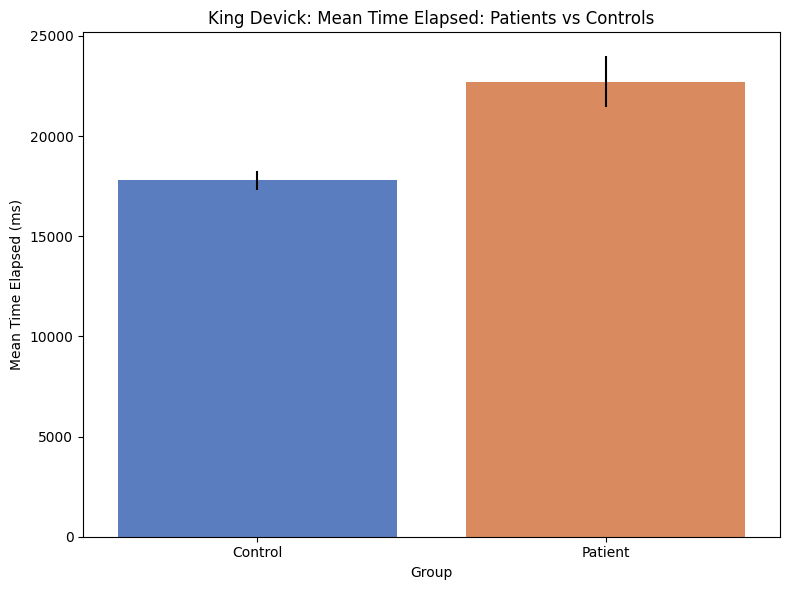

In [ ]:
# Function to summarize time elapsed
def summarize_time_elapsed(df, label):
    n = len(df["participant_id"].unique())  # Unique participants per group
    mean_time = df["time_elapsed"].mean()
    sd = np.std(df["time_elapsed"], ddof=1)
    se_time = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_time": mean_time, "sd": sd, "se_time": se_time}

# Summarize time elapsed for controls and patients
time_elapsed_summary = pd.DataFrame([
    summarize_time_elapsed(king_devick_fixations_right[king_devick_fixations_right["condition"] == "CONTROL"], "Control"),
    summarize_time_elapsed(king_devick_fixations_right[king_devick_fixations_right["condition"] == "PATIENT"], "Patient")
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=time_elapsed_summary, 
    x="group", 
    y="mean_time", 
    yerr=time_elapsed_summary["se_time"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("King Devick: Mean Time Elapsed: Patients vs Controls")
plt.ylabel("Mean Time Elapsed (ms)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

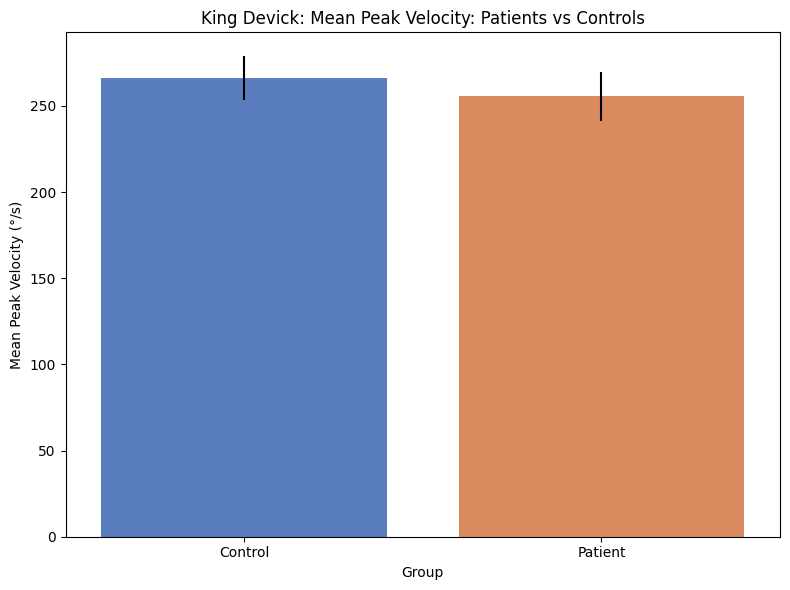

In [ ]:
# Function to summarize peak velocity
def summarize_peak_velocity(df, label):
    n = len(df["participant_id"].unique())  # Unique participants per group
    mean_velocity = df["peak_velocity"].mean()
    sd = np.std(df["peak_velocity"], ddof=1)
    se_velocity = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_velocity": mean_velocity, "sd": sd, "se_velocity": se_velocity}

# Summarize peak velocity for controls and patients
velocity_summary = pd.DataFrame([
    summarize_peak_velocity(king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"], "Control"),
    summarize_peak_velocity(king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"], "Patient")
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=velocity_summary, 
    x="group", 
    y="mean_velocity", 
    yerr=velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("King Devick: Mean Peak Velocity: Patients vs Controls")
plt.ylabel("Mean Peak Velocity (°/s)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

/tmp/ipykernel_11841/201117942.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


ValueError: 'yerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

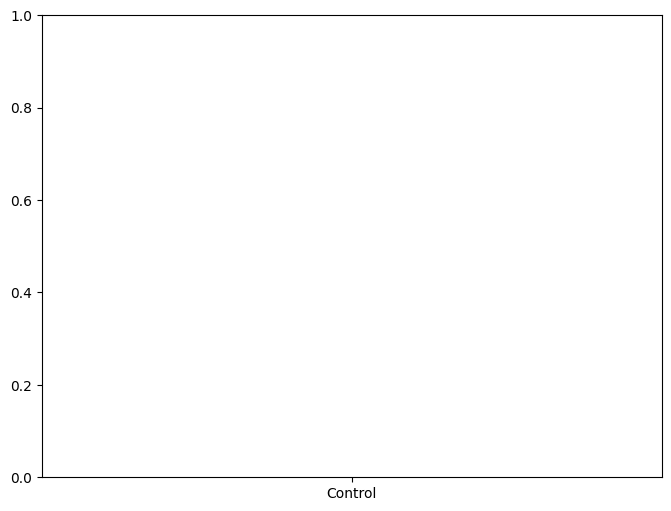

In [50]:
# Function to summarize average velocity
def summarize_average_velocity(df, label):
    n = len(df["participant_id"].unique())  # Unique participants per group
    mean_velocity = df["average_velocity"].mean()
    sd = np.std(df["average_velocity"], ddof=1)
    se_velocity = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_velocity": mean_velocity, "sd": sd, "se_velocity": se_velocity}

# Summarize average velocity for controls and patients
avg_velocity_summary = pd.DataFrame([
    summarize_average_velocity(king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"], "Control"),
    summarize_average_velocity(king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"], "Patient")
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=avg_velocity_summary, 
    x="group", 
    y="mean_velocity", 
    yerr=avg_velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("King Devick: Mean Average Velocity: Patients vs Controls")
plt.ylabel("Mean Average Velocity (°/s)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

/tmp/ipykernel_11841/3080771146.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


ValueError: 'yerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

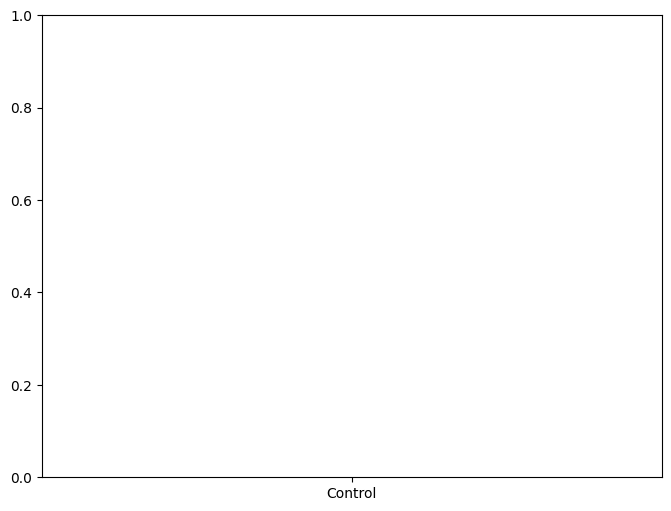

In [51]:
# Function to summarize saccade amplitude
def summarize_amplitude(df, label):
    n = len(df["participant_id"].unique())  # Unique participants per group
    mean_amplitude = df["amplitude"].mean()
    sd = np.std(df["amplitude"], ddof=1)
    se_amplitude = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_amplitude": mean_amplitude, "sd": sd, "se_amplitude": se_amplitude}

# Summarize saccade amplitude for controls and patients
amplitude_summary = pd.DataFrame([
    summarize_amplitude(king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"], "Control"),
    summarize_amplitude(king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"], "Patient")
])

# Plot the bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=amplitude_summary, 
    x="group", 
    y="mean_amplitude", 
    yerr=amplitude_summary["se_amplitude"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("King Devick: Mean Saccade Amplitude: Patients vs Controls")
plt.ylabel("Mean Amplitude (°)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

In [52]:
king_devick_saccades_right

,trial_id,eye,start_time,end_time,duration,start_x,start_y,end_x,end_y,amplitude,peak_velocity,participant_id,condition,average_velocity,stimulus_start_time,stimulus_end_time,num_mistakes,time_elapsed
0,0,R,2817914,2817974,60,300.8,273.5,688.4,355.3,7.13,349.0,128,KingDevick,118.833333,2817449.0,2827956.0,0,10507.0
3,0,R,2818199,2818255,56,672.7,360.0,974.4,583.1,6.84,405.0,128,KingDevick,122.142857,2817449.0,2827956.0,0,10507.0
4,0,R,2818440,2818450,10,955.1,582.4,966.1,557.5,0.49,60.0,128,KingDevick,49.000000,2817449.0,2827956.0,0,10507.0
6,0,R,2820387,2820433,46,990.5,582.8,660.7,433.4,6.60,291.0,128,KingDevick,143.478261,2817449.0,2827956.0,0,10507.0
7,0,R,2820798,2820855,57,636.8,418.3,903.2,491.5,5.05,259.0,128,KingDevick,88.596491,2817449.0,2827956.0,0,10507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,2,R,2180562,2180611,49,1338.9,682.0,1632.8,684.6,5.19,300.0,133,KingDevick,105.918367,2161448.0,2182398.0,0,20950.0
528,2,R,2181013,2181109,96,1662.2,672.7,365.1,669.3,22.62,484.0,133,KingDevick,235.625000,2161448.0,2182398.0,0,20950.0
530,2,R,2181257,2181293,36,359.8,681.1,290.1,685.1,1.22,180.0,133,KingDevick,33.888889,2161448.0,2182398.0,0,20950.0
532,2,R,2181830,2181877,47,281.8,718.6,631.3,720.9,6.16,420.0,133,KingDevick,131.063830,2161448.0,2182398.0,0,20950.0


/tmp/ipykernel_11841/3829051801.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


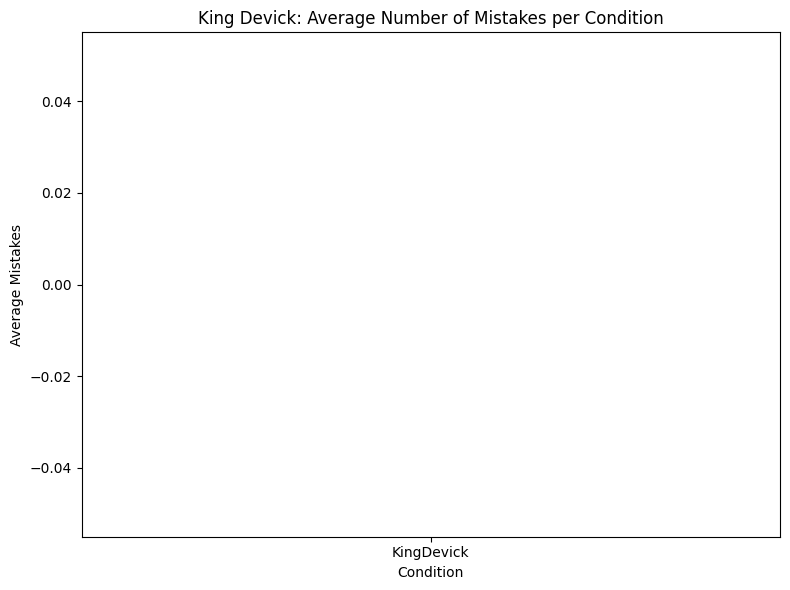

In [53]:
# Exclude participant 218
# pp218 is a clear outlier, either the mistakes weren't recorded properly, or the participant didn't understand the task
filtered_saccades = king_devick_saccades_right[king_devick_saccades_right["participant_id"] != 218] 

# Calculate mean, standard deviation, and count for mistakes per condition
mistakes_summary = filtered_saccades.groupby("condition")["num_mistakes"].agg(["mean", "std", "count"])
mistakes_summary["se"] = mistakes_summary["std"] / mistakes_summary.index.map(
    lambda cond: np.sqrt(filtered_saccades[filtered_saccades["condition"] == cond]["participant_id"].nunique())
)

# Plot bar chart with error bars
plt.figure(figsize=(8, 6))
sns.barplot(
    data=mistakes_summary.reset_index(),
    x="condition",
    y="mean",
    yerr=mistakes_summary["se"],
    capsize=0.2,
    palette="muted"
)

plt.title("King Devick: Average Number of Mistakes per Condition")
plt.ylabel("Average Mistakes")
plt.xlabel("Condition")
plt.tight_layout()
plt.show()

In [54]:
time_elapsed_summary = (
    king_devick_saccades_right.groupby(["participant_id", "trial_id","condition"])["time_elapsed"]
    .first()  # Take the first (or unique) value per trial
    .reset_index()
)

time_elapsed_summary['time_elapsed'] = time_elapsed_summary['time_elapsed'].astype(int)
time_elapsed_summary['trial_id'] = time_elapsed_summary['trial_id'].astype(int)

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute mean and standard deviation for each trial across participants
time_elapsed_summary = king_devick_fixations_right.groupby(["condition", "trial_id"])["time_elapsed"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = king_devick_fixations_right.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
time_elapsed_summary["se"] = time_elapsed_summary["std"] / participant_counts**0.5

# Separate control and patient data
time_elapsed_patient_summary = time_elapsed_summary.loc["PATIENT"].reset_index()
time_elapsed_control_summary = time_elapsed_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical to ensure discrete x-axis labels
time_elapsed_patient_summary["trial_id"] = time_elapsed_patient_summary["trial_id"].astype(str)
time_elapsed_control_summary["trial_id"] = time_elapsed_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    time_elapsed_patient_summary["trial_id"], 
    time_elapsed_patient_summary["mean"], 
    yerr=time_elapsed_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    time_elapsed_control_summary["trial_id"], 
    time_elapsed_control_summary["mean"], 
    yerr=time_elapsed_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

# Labels and title
plt.xlabel("Trial ID")
plt.ylabel("Average Time Elapsed (ms)")
plt.title("King Devick: Average Time Elapsed Over Trials (Patients vs Controls)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

KeyError: 'PATIENT'

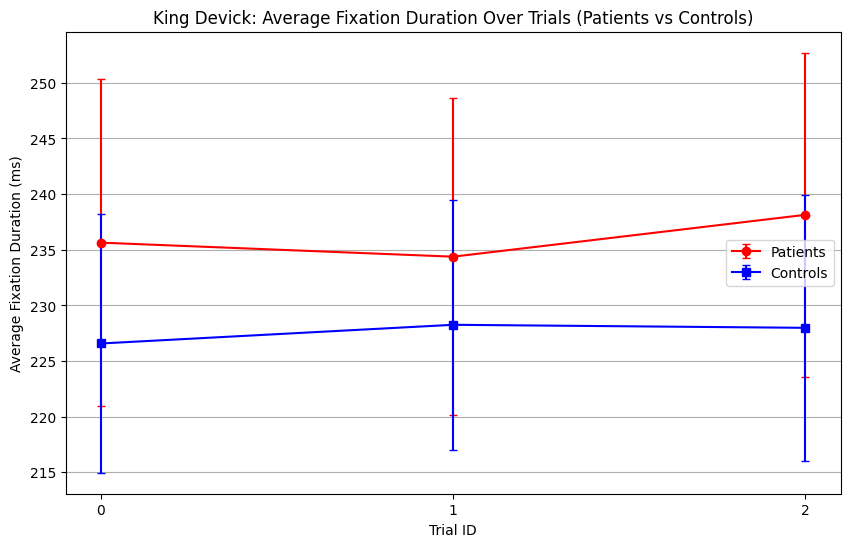

In [ ]:
# Compute mean and standard deviation for each trial across participants
fixation_duration_summary = king_devick_fixations_right.groupby(["condition", "trial_id"])["duration"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = king_devick_fixations_right.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
fixation_duration_summary["se"] = fixation_duration_summary["std"] / participant_counts**0.5

# Separate control and patient data
fixation_duration_patient_summary = fixation_duration_summary.loc["PATIENT"].reset_index()
fixation_duration_control_summary = fixation_duration_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical to ensure discrete x-axis labels
fixation_duration_patient_summary["trial_id"] = fixation_duration_patient_summary["trial_id"].astype(str)
fixation_duration_control_summary["trial_id"] = fixation_duration_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    fixation_duration_patient_summary["trial_id"], 
    fixation_duration_patient_summary["mean"], 
    yerr=fixation_duration_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    fixation_duration_control_summary["trial_id"], 
    fixation_duration_control_summary["mean"], 
    yerr=fixation_duration_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

# Labels and title
plt.xlabel("Trial ID")
plt.ylabel("Average Fixation Duration (ms)")
plt.title("King Devick: Average Fixation Duration Over Trials (Patients vs Controls)")
plt.legend()
plt.xticks(rotation=0)  # Ensure x-axis labels stay straight
plt.grid(True, axis='y')  # Only grid on y-axis for clarity

# Show the plot
plt.show()

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute mean and standard deviation for each trial across participants
peak_velocity_summary = king_devick_saccades_right.groupby(["condition", "trial_id"])["peak_velocity"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = king_devick_saccades_right.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
peak_velocity_summary["se"] = peak_velocity_summary["std"] / participant_counts**0.5

# Separate control and patient data
peak_velocity_patient_summary = peak_velocity_summary.loc["PATIENT"].reset_index()
peak_velocity_control_summary = peak_velocity_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical to ensure discrete x-axis labels
peak_velocity_patient_summary["trial_id"] = peak_velocity_patient_summary["trial_id"].astype(str)
peak_velocity_control_summary["trial_id"] = peak_velocity_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    peak_velocity_patient_summary["trial_id"], 
    peak_velocity_patient_summary["mean"], 
    yerr=peak_velocity_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    peak_velocity_control_summary["trial_id"], 
    peak_velocity_control_summary["mean"], 
    yerr=peak_velocity_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

# Labels and title
plt.xlabel("Trial ID")
plt.ylabel("Average Peak Velocity (°/s)")
plt.title("King Devick: Average Peak Velocity Over Trials (Patients vs Controls)")
plt.legend()
plt.xticks(rotation=0)  # Ensure x-axis labels stay straight
plt.grid(True, axis='y')  # Only grid on y-axis for clarity

# Show the plot
plt.show()

KeyError: 'PATIENT'

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute number of fixations per trial
fixation_count_summary = king_devick_fixations_right.groupby(["condition", "participant_id", "trial_id"]).size().reset_index(name="fixation_count")

# Compute mean and standard deviation per trial across participants
fixation_summary = fixation_count_summary.groupby(["condition", "trial_id"])["fixation_count"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = fixation_count_summary.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
fixation_summary["se"] = fixation_summary["std"] / participant_counts**0.5

# Separate control and patient data
fixation_patient_summary = fixation_summary.loc["PATIENT"].reset_index()
fixation_control_summary = fixation_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical for discrete x-axis labels
fixation_patient_summary["trial_id"] = fixation_patient_summary["trial_id"].astype(str)
fixation_control_summary["trial_id"] = fixation_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    fixation_patient_summary["trial_id"], 
    fixation_patient_summary["mean"], 
    yerr=fixation_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    fixation_control_summary["trial_id"], 
    fixation_control_summary["mean"], 
    yerr=fixation_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

# Labels and title
plt.xlabel("Trial ID")
plt.ylabel("Average Number of Fixations per Trial")
plt.title("King Devick: Average Number of Fixations Over Trials (Patients vs Controls)")
plt.legend()
plt.xticks(rotation=0)  # Ensure x-axis labels stay straight
plt.grid(True, axis='y')  # Only grid on y-axis for clarity

# Show the plot
plt.show()

KeyError: 'PATIENT'

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute number of saccades per trial
saccade_count_summary = king_devick_saccades_right.groupby(["condition", "participant_id", "trial_id"]).size().reset_index(name="saccade_count")

# Compute mean and standard deviation per trial across participants
saccade_summary = saccade_count_summary.groupby(["condition", "trial_id"])["saccade_count"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = saccade_count_summary.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
saccade_summary["se"] = saccade_summary["std"] / participant_counts**0.5

# Separate control and patient data
saccade_patient_summary = saccade_summary.loc["PATIENT"].reset_index()
saccade_control_summary = saccade_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical for discrete x-axis labels
saccade_patient_summary["trial_id"] = saccade_patient_summary["trial_id"].astype(str)
saccade_control_summary["trial_id"] = saccade_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    saccade_patient_summary["trial_id"], 
    saccade_patient_summary["mean"], 
    yerr=saccade_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    saccade_control_summary["trial_id"], 
    saccade_control_summary["mean"], 
    yerr=saccade_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

# Labels and title
plt.xlabel("Trial ID")
plt.ylabel("Average Number of Saccades per Trial")
plt.title("King Devick: Average Number of Saccades Over Trials (Patients vs Controls)")
plt.legend()
plt.xticks(rotation=0)  # Ensure x-axis labels stay straight
plt.grid(True, axis='y')  # Only grid on y-axis for clarity

# Show the plot
plt.show()

KeyError: 'PATIENT'

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute mean and standard deviation per trial across participants
saccade_amplitude_summary = king_devick_saccades_right.groupby(["condition", "trial_id"])["amplitude"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = king_devick_saccades_right.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
saccade_amplitude_summary["se"] = saccade_amplitude_summary["std"] / participant_counts**0.5

# Separate control and patient data
saccade_amplitude_patient_summary = saccade_amplitude_summary.loc["PATIENT"].reset_index()
saccade_amplitude_control_summary = saccade_amplitude_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical for discrete x-axis labels
saccade_amplitude_patient_summary["trial_id"] = saccade_amplitude_patient_summary["trial_id"].astype(str)
saccade_amplitude_control_summary["trial_id"] = saccade_amplitude_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    saccade_amplitude_patient_summary["trial_id"], 
    saccade_amplitude_patient_summary["mean"], 
    yerr=saccade_amplitude_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    saccade_amplitude_control_summary["trial_id"], 
    saccade_amplitude_control_summary["mean"], 
    yerr=saccade_amplitude_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

plt.title("King Devick: Mean Saccade Amplitude Over Trials (Patients vs Controls)")
plt.xlabel("Trial ID")
plt.ylabel("Mean Saccade Amplitude (degrees)")
plt.xticks(rotation=0)  # Ensure x-axis labels stay straight
plt.legend()
plt.grid(True, axis='y')  # Only grid on y-axis for clarity
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'PATIENT'

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute mean and standard deviation per trial across participants
avg_velocity_summary = king_devick_saccades_right.groupby(["condition", "trial_id"])["average_velocity"].agg(["mean", "std"])

# Compute the number of unique participants per trial and condition
participant_counts = king_devick_saccades_right.groupby(["condition", "trial_id"])["participant_id"].nunique()

# Calculate standard error based on unique participants
avg_velocity_summary["se"] = avg_velocity_summary["std"] / participant_counts**0.5

# Separate control and patient data
avg_velocity_patient_summary = avg_velocity_summary.loc["PATIENT"].reset_index()
avg_velocity_control_summary = avg_velocity_summary.loc["CONTROL"].reset_index()

# Convert trial_id to categorical for discrete x-axis labels
avg_velocity_patient_summary["trial_id"] = avg_velocity_patient_summary["trial_id"].astype(str)
avg_velocity_control_summary["trial_id"] = avg_velocity_control_summary["trial_id"].astype(str)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot patient data
plt.errorbar(
    avg_velocity_patient_summary["trial_id"], 
    avg_velocity_patient_summary["mean"], 
    yerr=avg_velocity_patient_summary["se"], 
    fmt="-o", label="Patients", color="red", capsize=3
)

# Plot control data
plt.errorbar(
    avg_velocity_control_summary["trial_id"], 
    avg_velocity_control_summary["mean"], 
    yerr=avg_velocity_control_summary["se"], 
    fmt="-s", label="Controls", color="blue", capsize=3
)

plt.title("King Devick: Mean Saccade Average Velocity Over Trials (Patients vs Controls)")
plt.xlabel("Trial ID")
plt.ylabel("Mean Average Velocity (deg/s)")
plt.xticks(rotation=0)  # Ensure x-axis labels stay straight
plt.legend()
plt.grid(True, axis='y')  # Only grid on y-axis for clarity
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'PATIENT'

In [61]:
from scipy.stats import ttest_ind

# T-test for Saccade Amplitude (mean per participant)
amplitude_control = king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"])["amplitude"].mean()
amplitude_patient = king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"])["amplitude"].mean()

stat_amplitude, pval_amplitude = ttest_ind(amplitude_patient, amplitude_control, equal_var=False)
print(f"Saccade Amplitude: t-statistic = {stat_amplitude:.4f}, p-value = {pval_amplitude:.4f}")

# T-test for Peak Velocity (mean per participant)
peak_velocity_control = king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"])["peak_velocity"].mean()
peak_velocity_patient = king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"])["peak_velocity"].mean()

stat_peak_velocity, pval_peak_velocity = ttest_ind(peak_velocity_patient, peak_velocity_control, equal_var=False)
print(f"Peak Velocity: t-statistic = {stat_peak_velocity:.4f}, p-value = {pval_peak_velocity:.4f}")

# T-test for Average Velocity (mean per participant)
avg_velocity_control = king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"])["average_velocity"].mean()
avg_velocity_patient = king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"])["average_velocity"].mean()

stat_avg_velocity, pval_avg_velocity = ttest_ind(avg_velocity_patient, avg_velocity_control, equal_var=False)
print(f"Average Velocity: t-statistic = {stat_avg_velocity:.4f}, p-value = {pval_avg_velocity:.4f}")

# T-test for Fixation Duration (mean per participant)
fixation_duration_control = king_devick_fixations_right[king_devick_fixations_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"])["duration"].mean()
fixation_duration_patient = king_devick_fixations_right[king_devick_fixations_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"])["duration"].mean()

stat_fixation_duration, pval_fixation_duration = ttest_ind(fixation_duration_patient, fixation_duration_control, equal_var=False)
print(f"Fixation Duration: t-statistic = {stat_fixation_duration:.4f}, p-value = {pval_fixation_duration:.4f}")

# Calculate the total number of saccades per participant
saccades_control_total = king_devick_saccades_right[king_devick_saccades_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"]).size()
saccades_patient_total = king_devick_saccades_right[king_devick_saccades_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"]).size()

# Perform independent t-test (Welch's t-test, assuming unequal variance)
stat_total_saccades, pval_total_saccades = ttest_ind(
    saccades_patient_total, 
    saccades_control_total, 
    equal_var=False
)

# Print results
print(f"Total Number of Saccades: t-statistic = {stat_total_saccades:.4f}, p-value = {pval_total_saccades:.4f}")

# Calculate the total number of fixations per participant
fixations_control_total = king_devick_fixations_right[king_devick_fixations_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"]).size()
fixations_patient_total = king_devick_fixations_right[king_devick_fixations_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"]).size()

# Perform independent t-test (Welch's t-test, assuming unequal variance)
stat_total_fixations, pval_total_fixations = ttest_ind(
    fixations_patient_total, 
    fixations_control_total, 
    equal_var=False
)
print(f"Total Number of Fixations: t-statistic = {stat_total_fixations:.4f}, p-value = {pval_total_fixations:.4f}")

# Time Elapsed Analysis
time_elapsed_summary_control = king_devick_fixations_right[king_devick_fixations_right["condition"] == "CONTROL"].groupby(["participant_id", "trial_id"])["time_elapsed"].first().reset_index()
time_elapsed_summary_patient = king_devick_fixations_right[king_devick_fixations_right["condition"] == "PATIENT"].groupby(["participant_id", "trial_id"])["time_elapsed"].first().reset_index()

# Perform independent t-test (Welch's t-test, assuming unequal variance)
stat_time_elapsed, pval_time_elapsed = ttest_ind(
    time_elapsed_summary_patient["time_elapsed"], 
    time_elapsed_summary_control["time_elapsed"], 
    equal_var=False
)

# Print results
print(f"Time Elapsed: t-statistic = {stat_time_elapsed:.4f}, p-value = {pval_time_elapsed:.4f}")

Saccade Amplitude: t-statistic = nan, p-value = nan
Peak Velocity: t-statistic = nan, p-value = nan
Average Velocity: t-statistic = nan, p-value = nan
Fixation Duration: t-statistic = nan, p-value = nan
Total Number of Saccades: t-statistic = nan, p-value = nan
Total Number of Fixations: t-statistic = nan, p-value = nan
Time Elapsed: t-statistic = nan, p-value = nan


/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/mnt/c/Users/idw

In [62]:
import pandas as pd
import statsmodels.api as sm

# Add condition labels
king_devick_fixations_right.loc[king_devick_fixations_right["condition"] == "CONTROL", "condition"] = "control"
king_devick_fixations_right.loc[king_devick_fixations_right["condition"] == "PATIENT", "condition"] = "patient"

# Convert time_elapsed to seconds
king_devick_fixations_right["time_elapsed_sec"] = king_devick_fixations_right["time_elapsed"] / 1000

# Encode the condition variable (1 for Patient, 0 for Control)
king_devick_fixations_right["condition_encoded"] = king_devick_fixations_right["condition"].apply(lambda x: 1 if x == "patient" else 0)

# Define independent (condition) and dependent (time_elapsed) variables
X = sm.add_constant(king_devick_fixations_right["condition_encoded"])
y = king_devick_fixations_right["time_elapsed_sec"]

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

# Save the summary to a text file
with open("time_elapsed_regression_summary.txt", "w") as f:
    f.write(model.summary().as_text())


ModuleNotFoundError: No module named 'statsmodels'

In [63]:
# --------------------------
# Linear regression for peak velocity
# --------------------------

# Encode the condition variable (1 for Patient, 0 for Control)
king_devick_saccades_right["condition_encoded"] = king_devick_saccades_right["condition"].apply(lambda x: 1 if x == "PATIENT" else 0)

# Define independent (condition) and dependent (peak_velocity) variables
X = sm.add_constant(king_devick_saccades_right["condition_encoded"])
y = king_devick_saccades_right["peak_velocity"]

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

# Save the summary to a text file
with open("peak_velocity_regression_summary.txt", "w") as f:
    f.write(model.summary().as_text())

/tmp/ipykernel_11841/1318621708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  king_devick_saccades_right["condition_encoded"] = king_devick_saccades_right["condition"].apply(lambda x: 1 if x == "PATIENT" else 0)


NameError: name 'sm' is not defined